In [1]:
import os

os.chdir("..")

In [2]:
import torch
from src.pipeline_flux_omini_kontext import FluxOminiKontextPipeline
from diffusers import FluxKontextPipeline
from PIL import Image


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`flash-attn` is not available or the version is too old. Please install `flash-attn>=2.6.3`.
`sageattention` is not available or the version is too old. Please install `sageattention>=2.1.1`.


In [3]:
# !export HF_HUB_CACHE=./cache

In [4]:
base_file = "living_room"
reference_file = "boy"

base_scene_path = f"assets/comparison/{base_file}.png"
reference_path = f"assets/comparison/{reference_file}.png"

## Normal FluxKontext Generation

In [5]:
pipe = FluxKontextPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16
)
pipe = pipe.to("cuda")


Loading pipeline components...: 100%|█████████████████████████████████████████| 7/7 [00:00<00:00,  7.14it/s]


In [6]:
base_scene = Image.open(base_scene_path).convert("RGB")
reference = Image.open(reference_path).convert("RGB")

width, height = base_scene.size

# Stitch the base scene and reference image
# Resize the reference image to match the height of the base scene
ref_aspect = reference.width / reference.height
new_ref_height = height
new_ref_width = int(ref_aspect * new_ref_height)
reference_resized = reference.resize((new_ref_width, new_ref_height))

# Create a new image wide enough to hold both images side by side
stitched_width = width + new_ref_width
stitched_img = Image.new("RGB", (stitched_width, height))
stitched_img.paste(base_scene, (0, 0))
stitched_img.paste(reference_resized, (width, 0))



prompt = "Add character to the image."


seed = torch.Generator().manual_seed(42)

result_img_base = pipe(
    prompt=prompt,
    image=stitched_img,
    num_inference_steps=28,
    height=height,
    width=width,
    generator=seed,
).images[0]

100%|███████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.23s/it]


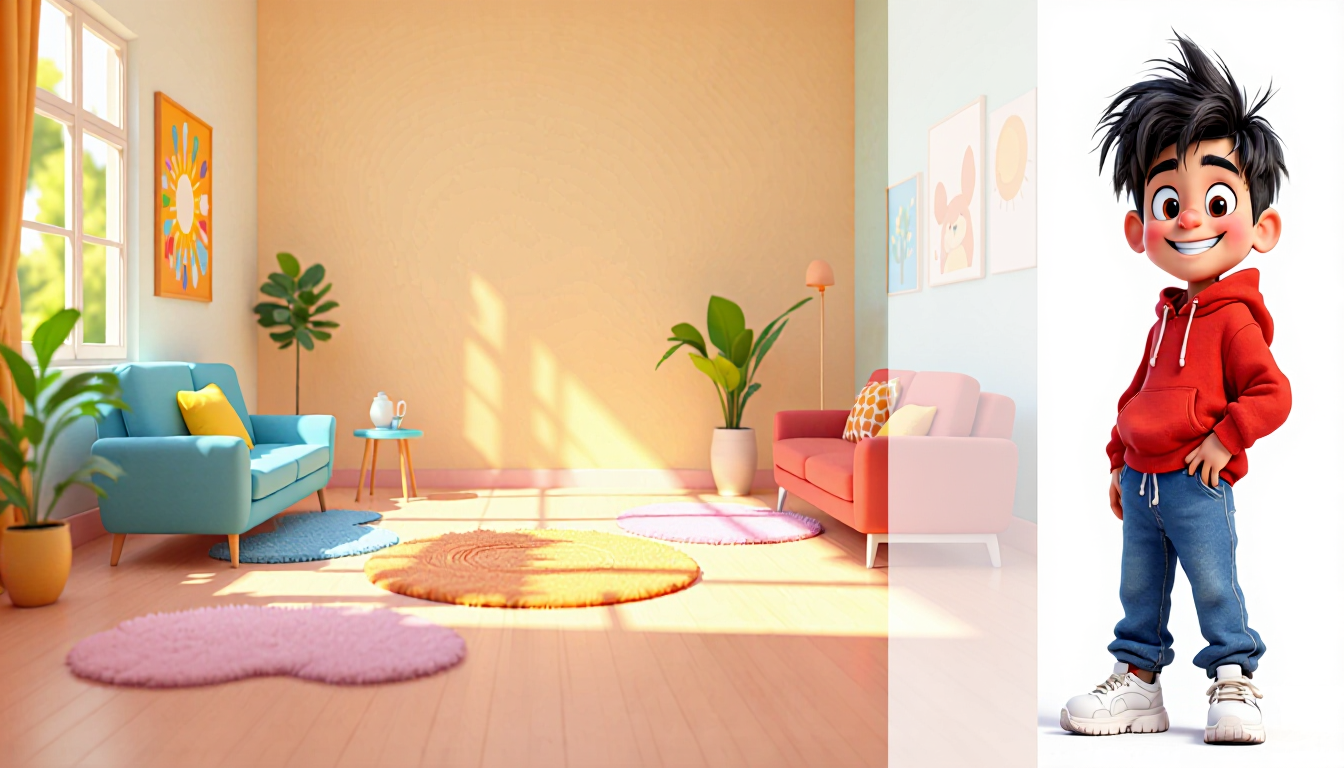

In [7]:
result_img_base

In [8]:
result_img_base.save(f"{base_file}_{reference_file}_vanilla.png")

## OminiKontext Generation

In [5]:
pipe = FluxOminiKontextPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-Kontext-dev", torch_dtype=torch.bfloat16
)
pipe = pipe.to("cuda")

Loading checkpoint shards: 100%|██████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]

Loading pipeline components...: 100%|█████████████████████████████████████████| 7/7 [00:00<00:00,  7.08it/s]


In [6]:
base_scene = Image.open(base_scene_path).convert("RGB")
reference = Image.open(reference_path).resize((256, 256)).convert("RGB")

width, height = base_scene.size


prompt = "Add character to the image."


seed = torch.Generator().manual_seed(42)

result_img = pipe(
    prompt=prompt,
    image=base_scene,
    reference=reference,
    reference_delta=[0, 0, (1024 + 512)//16],
    num_inference_steps=28,
    height=height,
    width=width,
    generator=seed,
).images[0]



100%|███████████████████████████████████████████████████████████████████████| 28/28 [00:35<00:00,  1.28s/it]


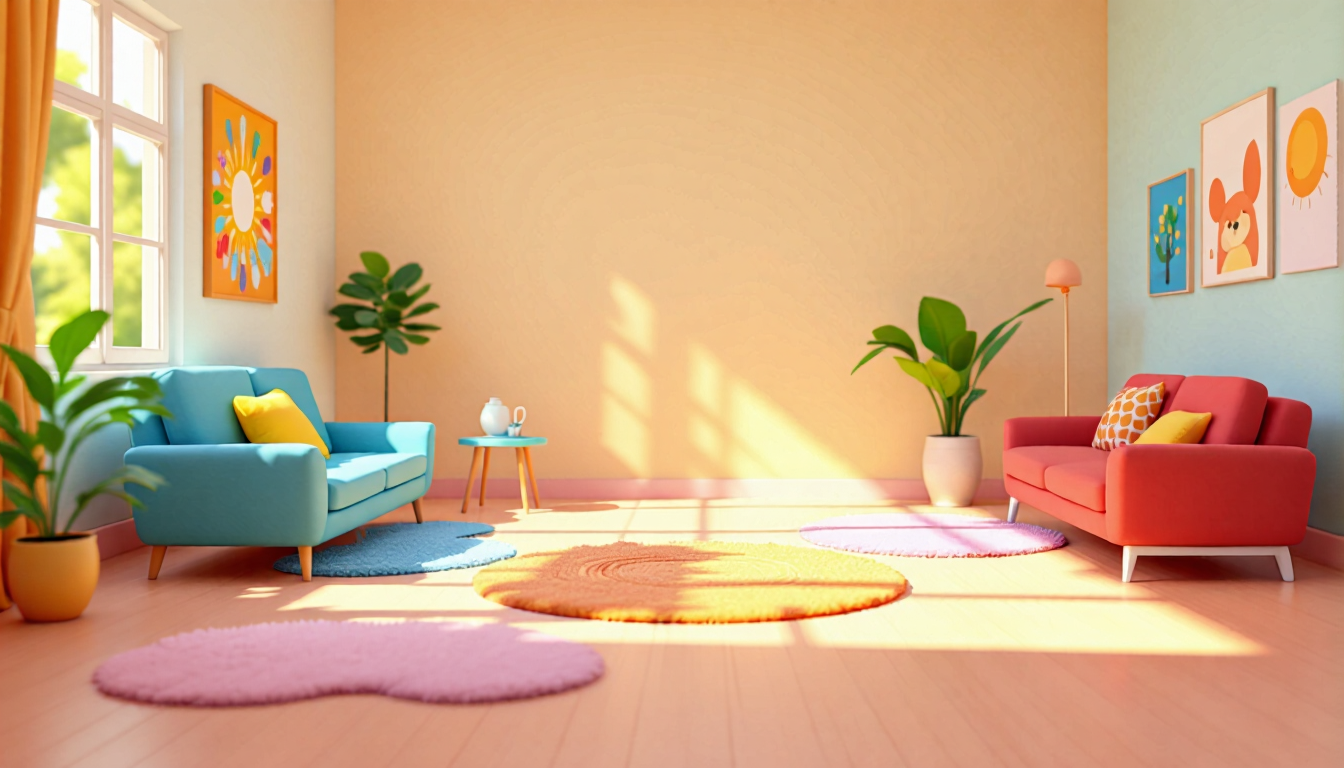

In [7]:
result_img

In [8]:
result_img.save(f"{base_file}_{reference_file}_omini_no_lora.png")

In [9]:
pipe.load_lora_weights(
    "saquiboye/omini-kontext-character",
    weight_name="character_5000.safetensors",
    adapter_name="lora_weights"
)

Loading adapter weights from state_dict led to unexpected keys found in the model: single_transformer_blocks.0.proj_out.lora_A.lora_weights.weight, single_transformer_blocks.0.proj_out.lora_B.lora_weights.weight, single_transformer_blocks.1.proj_out.lora_A.lora_weights.weight, single_transformer_blocks.1.proj_out.lora_B.lora_weights.weight, single_transformer_blocks.2.proj_out.lora_A.lora_weights.weight, single_transformer_blocks.2.proj_out.lora_B.lora_weights.weight, single_transformer_blocks.3.proj_out.lora_A.lora_weights.weight, single_transformer_blocks.3.proj_out.lora_B.lora_weights.weight, single_transformer_blocks.4.proj_out.lora_A.lora_weights.weight, single_transformer_blocks.4.proj_out.lora_B.lora_weights.weight, single_transformer_blocks.5.proj_out.lora_A.lora_weights.weight, single_transformer_blocks.5.proj_out.lora_B.lora_weights.weight, single_transformer_blocks.6.proj_out.lora_A.lora_weights.weight, single_transformer_blocks.6.proj_out.lora_B.lora_weights.weight, single_

In [10]:
seed = torch.Generator().manual_seed(42)

result_img = pipe(
    prompt=prompt,
    image=base_scene,
    reference=reference,
    reference_delta=[0, 0, (1024 + 512)//16],
    num_inference_steps=28,
    height=height,
    width=width,
    generator=seed,
).images[0]


100%|███████████████████████████████████████████████████████████████████████| 28/28 [00:42<00:00,  1.50s/it]


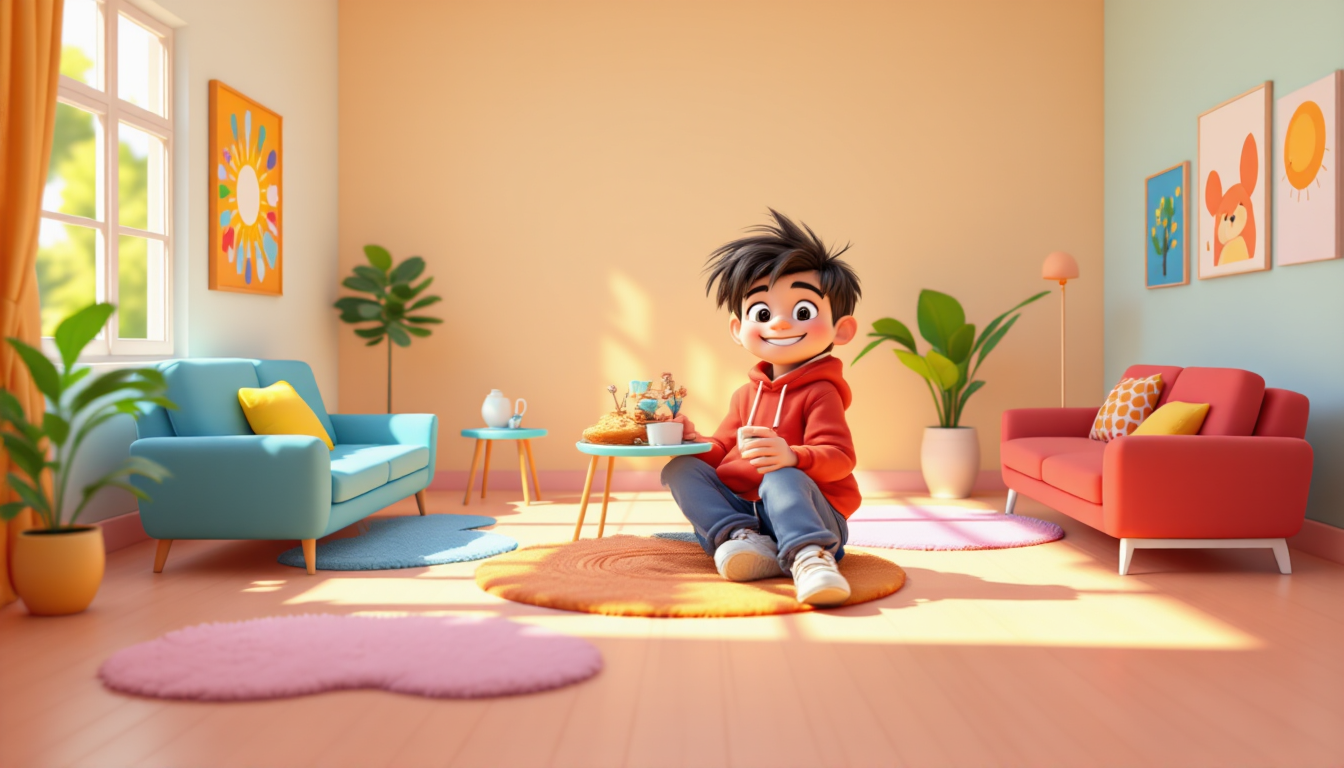

In [11]:
result_img

In [12]:
result_img.save(f"{base_file}_{reference_file}_omini_with_lora.png")